In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

We begin by importing the following three data sets.

In [2]:
df_strikes = pd.read_csv("my_data/strikes_2000_2019.csv")
df_flights = pd.read_csv("my_data/schedule_T3.csv")
df_expenses = pd.read_csv("my_data/schedule_P52.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,77,86,96,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Each row of df_strikes corresponds a report to the FAA of an aircraft wildlife strike.

The rows of df_flights contain flight statistics for a given year, quarter, US airport, and airline.
In particular, we want to use the data on the number of departing domestic and international flights in each row.

Each row of the dataframe df_expenses is determined by a year, quarter, world region, airline, and aircraft type.
The rows record information about the operating expenses of that particular aircraft type for that particular airline and quarter. We will in particular be interested in the total maintenance costs.

# Flight Counts

We begin by restricting to the years we care about in the flights dataframe.

In [3]:
flight_counts = df_flights.copy().loc[(df_flights.YEAR <= 2019)&(df_flights.YEAR >= 2000)]

We want each row to correspond to a particular year, quarter, and airline, so we make "buckets" corresponding to these variables and calculate the number of departure flights in each bucket.

In [4]:
flight_row_id = ['YEAR', 'QUARTER', 'UNIQUE_CARRIER', 'UNIQUE_CARRIER_NAME']

# The variable 'REV_ACRFT_DEP_PERF_510' stores the number of departing flights
flight_counts = flight_counts.groupby(flight_row_id)['REV_ACRFT_DEP_PERF_510'].sum().reset_index()

Next we rename the columns and create a new 'DATE' column which records the date of the first day of the quarter of the given year and month as a Pandas timestamp.

In [5]:
flight_counts.columns = ['YEAR', 'QUARTER', 'ICAO', 'AIRLINE', 'FLIGHTS']

In [6]:
# This function eats a row of a dataframe with 'YEAR' and 'QUARTER' columns and 
# spits out the date of the first day of the quarter as a Pandas timestamp.
YQ_to_YMD = lambda x: pd.Timestamp(x.YEAR,x.QUARTER*3-2,1)

In [7]:
flight_counts.insert(loc=0, column='DATE', value=flight_counts.apply(YQ_to_YMD, axis=1))

We no longer need 'YEAR' and 'QUARTER', so we drop them from the dataframe.

In [8]:
flight_counts = flight_counts.drop(['YEAR', 'QUARTER'], axis=1)

In [9]:
flight_counts.head()

,DATE,ICAO,AIRLINE,FLIGHTS
0,2000-01-01,1I,Sky Trek International Airlines,612.0
1,2000-01-01,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,3021.0
2,2000-01-01,5X,United Parcel Service,29591.0
3,2000-01-01,5Y,Atlas Air Inc.,193.0
4,2000-01-01,8C,Air Transport International,2870.0


# Wildlife Strikes

Moving on to the strikes dataframe, we will count the number of entries in each quarter for each airline.
We will also count the number of flights with minor, substantial, and destroyed levels of damage in each quarter for each airline. The majority of entries do not record a cost of repairs, but we will add up the costs in each quarter for each airline.

For our purposes, we only need the following four columns.

In [10]:
strike_variables = ['INCIDENT_DATE ', 'OPERATOR_ID', 'DAMAGE', 'COST_REPAIRS']
strikes = df_strikes.copy()[strike_variables]
strikes.columns = ['INCIDENT_DATE', 'IATA', 'DAMAGE', 'COST']

As for the flight_counts data, we convert the dates to the Pandas timestamp of the first day of the quarter. The dataframe is already limited to the correct time period, so we won't need to narrow our dates.

In [11]:
# This takes about a minute to run on my computer
strikes.INCIDENT_DATE = strikes.INCIDENT_DATE.apply(pd.Timestamp)
quarter_time = lambda x: pd.Timestamp(x.year, x.quarter*3-2, 1)
strikes.insert(loc=0, column='DATE', value=strikes.INCIDENT_DATE.apply(quarter_time))

Now we one-hot encode the minor, substantial, and destroyed values of the DAMAGE variable.

In [12]:
strikes['COUNT'] = 1
strikes['DAMAGE_M'] = 0  #minor
strikes['DAMAGE_S'] = 0  #substantial
strikes['DAMAGE_D'] = 0  #destroyed

In [13]:
strikes.loc[strikes.DAMAGE == 'M', 'DAMAGE_M'] = 1
strikes.loc[strikes.DAMAGE == 'S', 'DAMAGE_S'] = 1
strikes.loc[strikes.DAMAGE == 'D', 'DAMAGE_D'] = 1

In [14]:
strikes.sample(40)

,DATE,INCIDENT_DATE,IATA,DAMAGE,COST,COUNT,DAMAGE_M,DAMAGE_S,DAMAGE_D
159887,2017-07-01,2017-09-05,UAL,N,NaN,1,0,0,0
4911,2000-10-01,2000-10-15,UAL,N,NaN,1,0,0,0
101914,2013-01-01,2013-03-15,QXE,N,NaN,1,0,0,0
103744,2013-04-01,2013-05-15,UNK,NaN,NaN,1,0,0,0
39045,2006-04-01,2006-05-07,NWA,N,NaN,1,0,0,0
20069,2003-04-01,2003-05-05,EGF,N,NaN,1,0,0,0
54442,2007-10-01,2007-12-04,ASH,N,NaN,1,0,0,0
20422,2004-01-01,2004-03-02,UNK,NaN,NaN,1,0,0,0
139027,2015-10-01,2015-12-19,AAL,N,NaN,1,0,0,0
68770,2009-10-01,2009-10-30,SKW,N,NaN,1,0,0,0


Now we are ready to sum up the 'COST', 'COUNT', 'DAMAGE_M', 'DAMAGE_S', and 'DAMAGE_D' variables for each quarter and airline.

In [15]:
strikes = strikes.groupby(['DATE', 'IATA'])[['COST', 'COUNT', 'DAMAGE_M', 'DAMAGE_S', 
                                            'DAMAGE_D']].sum().reset_index()

So, for example, in the first quarter of 2000 American Airlines (AAL) recorded 49 bird strikes, 2 of which caused substantial damage.

In [16]:
strikes.head()

,DATE,IATA,COST,COUNT,DAMAGE_M,DAMAGE_S,DAMAGE_D
0,2000-01-01,1AAH,0.0,3,0,0,0
1,2000-01-01,1ASQ,0.0,1,0,0,0
2,2000-01-01,1AWE,50000.0,17,1,2,0
3,2000-01-01,AAL,104000.0,49,4,2,0
4,2000-01-01,ABX,0.0,11,1,0,0


# Maintenance Expenses

 Each row in the dataframe corresponds to an aircraft type for a particular year, quarter, world region, and airline. We begin by limiting to domestic flights from 2000 to 2019.

In [17]:
expenses = df_expenses.copy().loc[(df_expenses.YEAR <= 2019)&(df_expenses.YEAR >= 2000)
                                                            &(df_expenses.REGION == 'D')]

# Rows of financial are determined by YEAR, QUARTER, UNIQUE_CARRIER_NAME/UNIQUE_CARRIER, and AIRCRAFT_TYPE

For each airline, we find the total direct maintenance costs, total flight hours, total costs of flying operations, and total airline operating expenses (in thousands) in each quarter.

In [18]:
# The numerical variables we care about
expenses_vars = ['TOT_DIR_MAINT', 'TOTAL_AIR_HOURS', 'TOT_FLY_OPS', 'TOT_AIR_OP_EXPENSES']
# ['TOT_AIR_OP_EXPENSES', 'TOTAL_AIR_HOURS', 'AIR_DAYS_ASSIGN', 'TOT_FLY_OPS', 'TOT_DIR_MAINT', 'ENGINE_LABOR', 
# 'ENGINE_REPAIRS', 'AIRFRAME_LABOR', 'AIRFRAME_REPAIR']

# The variables whose values will uniquely specify each row in our new dataframe
expenses_row_id = ['YEAR', 'QUARTER', 'UNIQUE_CARRIER']

expenses = expenses.groupby(expenses_row_id)[expenses_vars].sum().reset_index()

Then we add a column of the datas of the first day of given 'YEAR' and 'QUARTER' values as a Pandas timestamp. 

In [19]:
combine_times = lambda x: pd.Timestamp(x.YEAR,x.QUARTER*3-2,1)

expenses.insert(loc=0, column='DATE', value=expenses[['YEAR','QUARTER']].apply(combine_times, axis=1))

Next we calculate a new variable 'ADJ_MAINT' which is the dollars of direct maintenance expenses per hour of flight.

In [20]:
# adj_maint = expenses.TOT_DIR_MAINT/(expenses.TOT_AIR_OP_EXPENSES - expenses.TOT_DIR_MAINT)
# adj_maint = expenses.TOT_DIR_MAINT/expenses.TOT_AIR_OP_EXPENSES
# adj_maint = expenses.TOT_DIR_MAINT/expenses.TOT_FLY_OPS
adj_maint = expenses.TOT_DIR_MAINT/expenses.TOTAL_AIR_HOURS
# adj_maint = expenses.TOT_DIR_MAINT/(expenses.TOT_FLY_OPS*expenses.TOTAL_AIR_HOURS)

In [21]:
expenses.insert(loc=5, column='ADJ_MAINT', value=adj_maint)

Now that we've made use of the following variables, we can drop them and then rename the remaining columns.

In [22]:
expenses = expenses.drop(['YEAR', 'QUARTER', 'TOTAL_AIR_HOURS', 'TOT_FLY_OPS', 
                          'TOT_AIR_OP_EXPENSES'], axis=1)

In [23]:
expenses.columns

Index(['DATE', 'UNIQUE_CARRIER', 'TOT_DIR_MAINT', 'ADJ_MAINT'], dtype='object')

In [24]:
expenses.columns = ['DATE', 'ICAO', 'TOT_DIR_MAINT', 'ADJ_MAINT']

In [25]:
expenses.head()

,DATE,ICAO,TOT_DIR_MAINT,ADJ_MAINT
0,2000-01-01,5X,87281.00,inf
1,2000-01-01,8C,12581.48,inf
2,2000-01-01,AA,194325.00,inf
3,2000-01-01,AQ,8486.13,inf
4,2000-01-01,AS,28112.00,inf


For dates before 2003, the airlines all recorded 0 flight hours, so 'ADJ_MAINT' is infinite. PyPlot will just omit these points, so they won't cause us any trouble.

# Merging Dataframes

Now we will merge the flight_counts, strikes, and expenses dataframes.

We begin by writing lists of the ICAO and IATA codes of the airlines we care about. We will create a dictionary to translate between the two codes.

In [26]:
IATA = ['UPS', 'AAL', 'DAL', 'FDX', 'UAL', 'SWA'] 
#['UPS', 'AAL', 'ASA', 'JBU', 'DAL', 'FFT', 'FDX', 'AAY', 'NKS', 'UAL', 'SWA']
ICAO = ['5X', 'AA', 'DL', 'FX', 'UA', 'WN'] 
#['5X', 'AA', 'AS', 'B6', 'DL', 'F9', 'FX', 'G4', 'NK', 'UA', 'WN']
AL_ID = {ICAO[i]: IATA[i] for i in range(len(IATA))}

We restrict our dataframes to the above airlines and we insert an 'IATA' column into the restricted flight_counts dataframe to help with merging.

In [27]:
flight_counts_re = flight_counts[flight_counts.ICAO.isin(ICAO)]
strikes_re = strikes[strikes.IATA.isin(IATA)]
expenses_re = expenses[expenses.ICAO.isin(ICAO)]

In [28]:
flight_counts_re.insert(loc=1, column='IATA', value=flight_counts_re.ICAO.apply(lambda x: AL_ID[x]))
# expenses_re.insert(loc=1, column='IATA', value=expenses_re.ICAO.apply(lambda x: AL_ID[x]))

In [29]:
flight_counts_re.head(2)

,DATE,IATA,ICAO,AIRLINE,FLIGHTS
2,2000-01-01,UPS,5X,United Parcel Service,29591.0
5,2000-01-01,AAL,AA,American Airlines Inc.,193165.0


In [30]:
expenses_re.head(2)

,DATE,ICAO,TOT_DIR_MAINT,ADJ_MAINT
0,2000-01-01,5X,87281.0,inf
2,2000-01-01,AA,194325.0,inf


In [31]:
strikes_re.head(2)

,DATE,IATA,COST,COUNT,DAMAGE_M,DAMAGE_S,DAMAGE_D
3,2000-01-01,AAL,104000.0,49,4,2,0
26,2000-01-01,DAL,0.0,43,4,1,0


Starting with flight_counts_re, we create a new dataframe by merging with expenses_re and then with strikes_re on the quarter and airline.

In [32]:
strike_expenses = pd.merge_ordered(flight_counts_re, expenses_re, on=['DATE', 'ICAO'])

In [33]:
strike_expenses.head(2)

,DATE,IATA,ICAO,AIRLINE,FLIGHTS,TOT_DIR_MAINT,ADJ_MAINT
0,2000-01-01,UPS,5X,United Parcel Service,29591.0,87281.0,inf
1,2000-01-01,AAL,AA,American Airlines Inc.,193165.0,194325.0,inf


In [34]:
strike_expenses = pd.merge_ordered(strike_expenses, strikes_re, on=['DATE', 'IATA'])

In [35]:
strike_expenses.head(2)

,DATE,IATA,ICAO,AIRLINE,FLIGHTS,TOT_DIR_MAINT,ADJ_MAINT,COST,COUNT,DAMAGE_M,DAMAGE_S,DAMAGE_D
0,2000-01-01,AAL,AA,American Airlines Inc.,193165.0,194325.0,inf,104000.0,49.0,4.0,2.0,0.0
1,2000-01-01,DAL,DL,Delta Air Lines Inc.,229186.0,150561.0,inf,0.0,43.0,4.0,1.0,0.0


We get some Nan entries from our merge, since for example, not every quarter-airline pair in the flight_counts_re data has a recorded strike.

In [36]:
strike_expenses = strike_expenses.fillna(0)

# Calculated Variables

Now that our dataframes are merged, we can do some calculations using data from different datasets.

First we define the following columns for the number of strikes, minor strikes, substantial strikes, and destroyed-level strikes per 10 thousand flights.

In [37]:
strike_expenses['STRIKE_INDEX'] = np.round(strike_expenses.COUNT*10000/strike_expenses.FLIGHTS, 2)
strike_expenses['STRIKE_INDEX_M'] = np.round(strike_expenses.DAMAGE_M*10000/strike_expenses.FLIGHTS, 2)
strike_expenses['STRIKE_INDEX_S'] = np.round(strike_expenses.DAMAGE_S*10000/strike_expenses.FLIGHTS, 2)
strike_expenses['STRIKE_INDEX_D'] = np.round(strike_expenses.DAMAGE_D*10000/strike_expenses.FLIGHTS, 2)

Next, we define a function which sends an ICAO code identifying a particular airline to the dataframe which restricts the strike_expenses dataframe to the given airline and then adds columns which subtract off a seven quarter moving average from 5 key variables. The idea is that these differences will capture the seasonal variation in the maintenance expense and strike variables.

In [38]:
def seasonality_df(ICAO_code):
    airline = strike_expenses.copy().loc[strike_expenses.ICAO == ICAO_code]
    airline = airline.reset_index(drop=True)
    airline['MAINT_MOV_AVG'] = np.nan
    airline['STRIKE_MOV_AVG'] = np.nan
    for i in airline.loc[3:len(airline)-4].index:
        airline.loc[i,'MAINT_MOV_AVG'] = sum([airline.ADJ_MAINT.values[j] for j in [i-3,i-2,i-1,i,i+1,i+2,i+3]])/7  
        airline.loc[i,'STRIKE_MOV_AVG'] = sum([airline.STRIKE_INDEX.values[j] for j in [i-3,i-2,i-1,i,i+1,i+2,i+3]])/7
        airline.loc[i,'STRIKE_M_MOV_AVG'] = sum([airline.STRIKE_INDEX_M.values[j] for j in [i-3,i-2,i-1,i,i+1,i+2,i+3]])/7
        airline.loc[i,'STRIKE_S_MOV_AVG'] = sum([airline.STRIKE_INDEX_S.values[j] for j in [i-3,i-2,i-1,i,i+1,i+2,i+3]])/7
        airline.loc[i,'STRIKE_D_MOV_AVG'] = sum([airline.STRIKE_INDEX_D.values[j] for j in [i-3,i-2,i-1,i,i+1,i+2,i+3]])/7
    airline['MAINT_SEAS_VAR'] = airline['ADJ_MAINT'] - airline['MAINT_MOV_AVG']
    airline['STRIKE_SEAS_VAR'] = airline['STRIKE_INDEX'] - airline['STRIKE_MOV_AVG']
    airline['STRIKE_M_SEAS_VAR'] = airline['STRIKE_INDEX_M'] - airline['STRIKE_M_MOV_AVG']
    airline['STRIKE_S_SEAS_VAR'] = airline['STRIKE_INDEX_S'] - airline['STRIKE_S_MOV_AVG']
    airline['STRIKE_D_SEAS_VAR'] = airline['STRIKE_INDEX_D'] - airline['STRIKE_D_MOV_AVG']
    return airline


The following dictionary associates an airline's ICAO code to its seasonality dataframe, described above.

In [39]:
expenses_dict = {AL_ID[code]: seasonality_df(code) for code in ICAO}

# Exploring the Data

Our first graph is the number of bird strikes per ten thousand flights by airline. The dashed lines are the smoothed curves given by the seven quarter moving average.

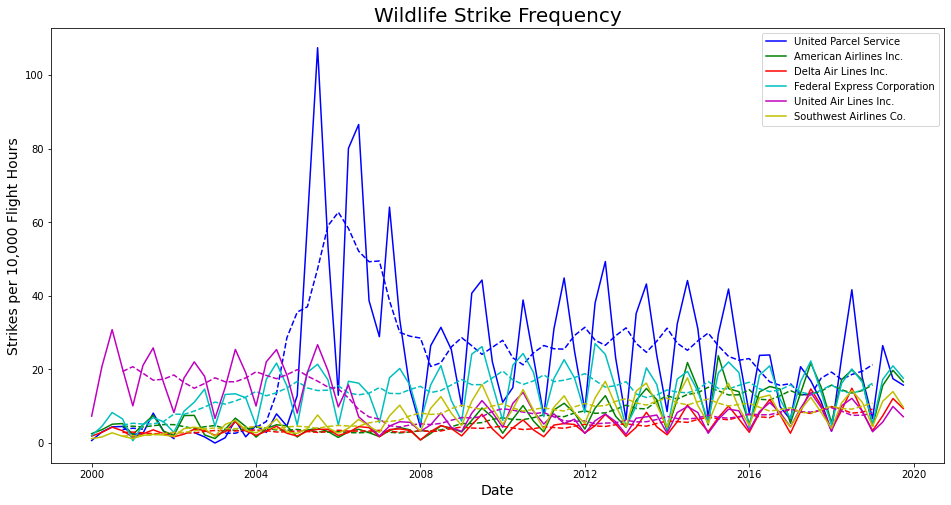

In [40]:
plt.figure(figsize=(16,8))

for i in range(len(IATA)):
    color = ['b', 'g', 'r', 'c', 'm', 'y'][i]
    plt.plot(expenses_dict[IATA[i]].DATE, 
             expenses_dict[IATA[i]].STRIKE_INDEX, 
             label=expenses_dict[IATA[i]].AIRLINE.iloc[0], c = color)
    plt.plot(expenses_dict[IATA[i]].DATE, expenses_dict[IATA[i]].STRIKE_MOV_AVG, '--', c = color)

plt.xlabel("Date", fontsize = 14)
plt.ylabel("Strikes per 10,000 Flight Hours", fontsize = 14)
plt.title("Wildlife Strike Frequency", fontsize = 20)
    
plt.legend(fontsize=14)
plt.legend()

plt.show()

This data is seasonal with a peak in the third quarter of each year for each airline.

Our next graph is of the dollars of maintenance expenses per flight hour.

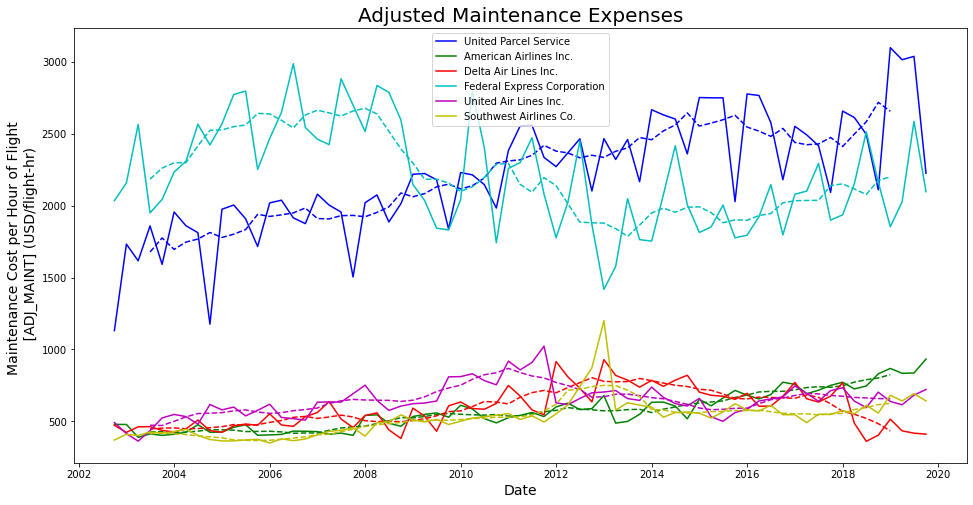

In [41]:
plt.figure(figsize=(16,8))

for i in range(len(IATA)):
    color = ['b', 'g', 'r', 'c', 'm', 'y'][i]
    plt.plot(expenses_dict[IATA[i]].DATE, 
             expenses_dict[IATA[i]].ADJ_MAINT, 
             label=expenses_dict[IATA[i]].AIRLINE.iloc[0], c = color)
    plt.plot(expenses_dict[IATA[i]].DATE, expenses_dict[IATA[i]].MAINT_MOV_AVG, '--', c = color)

plt.xlabel("Date", fontsize = 14)
plt.ylabel("Maintenance Cost per Hour of Flight \n [ADJ_MAINT] (USD/flight-hr)", fontsize = 14)
plt.title("Adjusted Maintenance Expenses", fontsize = 20)
    
plt.legend(fontsize=14)
plt.legend()

plt.show()

It looks like the adjusted maintenance costs could also be seasonal. To check, we subtract off the smoothed curves and plot the resulting curves against their 4-quarter lag dataframes.

In [42]:
# I stole this code from the Time Series lecture notebook.
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

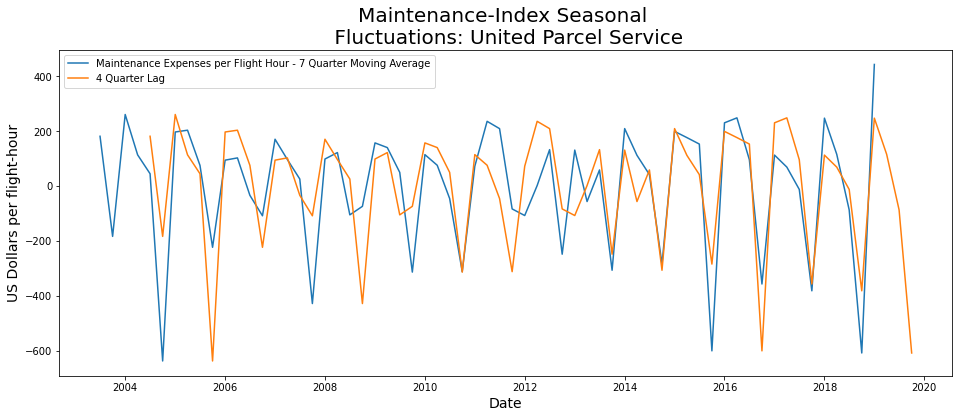

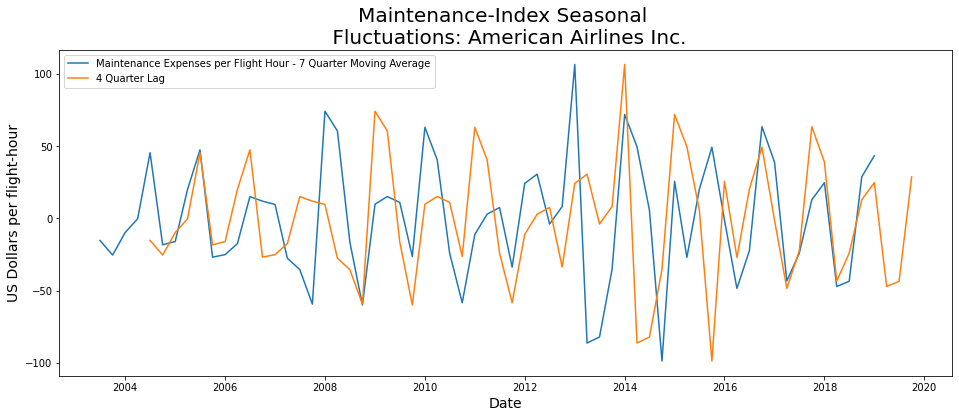

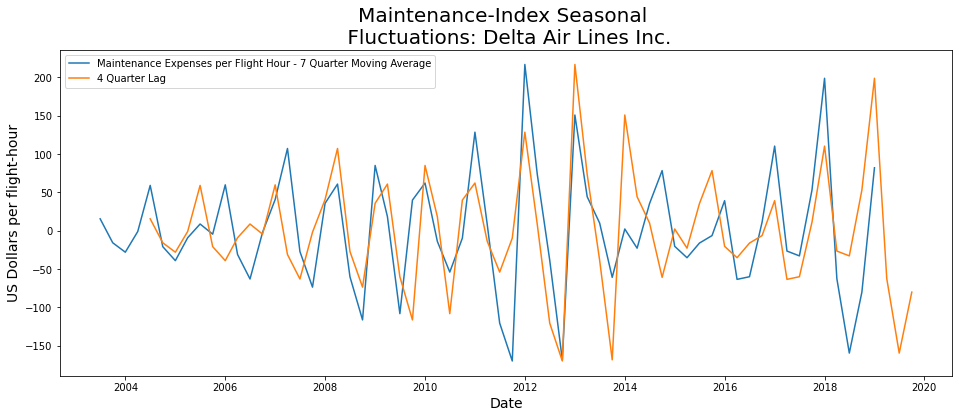

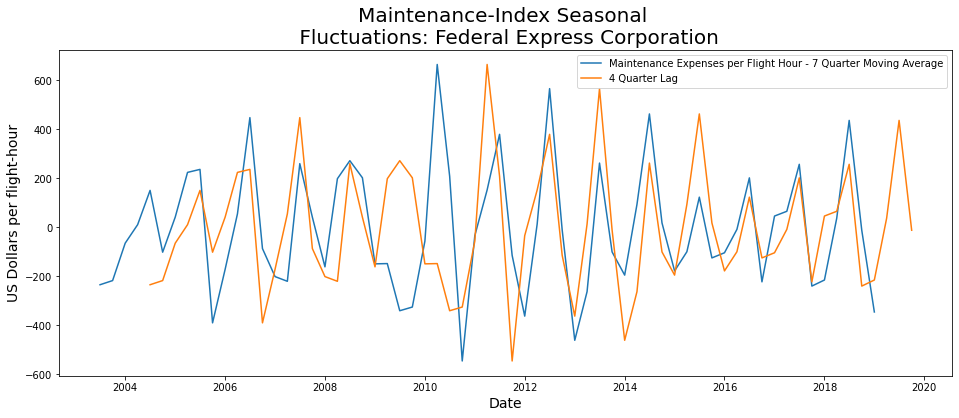

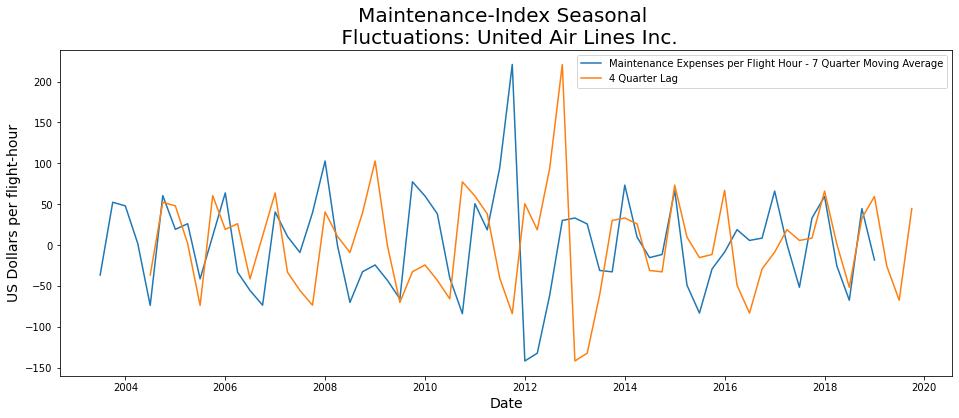

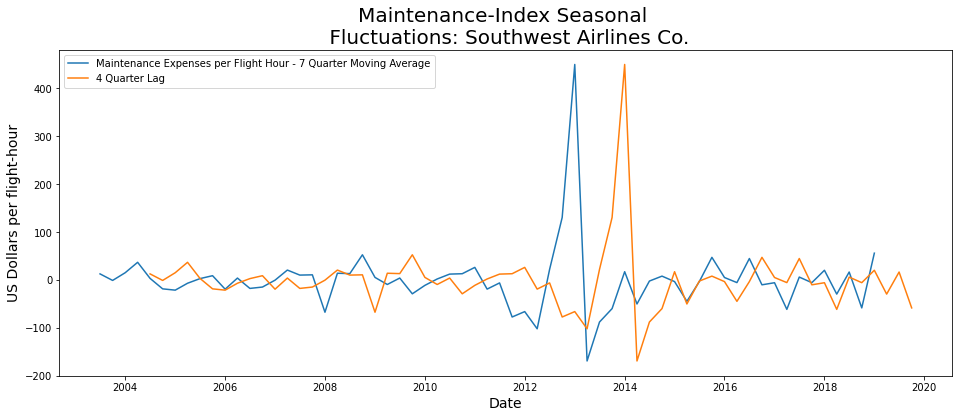

In [43]:
for code in IATA:
    plt.figure(figsize=(16,6))

    plt.plot(expenses_dict[code].DATE, expenses_dict[code].MAINT_SEAS_VAR, label='Maintenance Expenses per Flight Hour - 7 Quarter Moving Average') 
    plt.plot(expenses_dict[code].DATE, make_lag_df(expenses_dict[code], 'MAINT_SEAS_VAR', 4).MAINT_SEAS_VAR_lag, label='4 Quarter Lag')
    
    plt.xlabel("Date", fontsize = 14)
    plt.ylabel("US Dollars per flight-hour", fontsize = 14)
    plt.title('Maintenance-Index Seasonal \n Fluctuations: ' + expenses_dict[code].AIRLINE.iloc[0], 
              fontsize = 20)
        
    plt.legend(fontsize=14)
    plt.legend()
    
    plt.show()

UPS and FedEx definitely look seasonal. American Airlines and Delta may be seasonal too. To make this precise, we calculate the autocorrelations for a 4 quarter lag.

In [44]:
for code in IATA:  
    correlation_matrix = make_lag_df(expenses_dict[code], 'MAINT_SEAS_VAR', 4)[['MAINT_SEAS_VAR', 
                                                                                'MAINT_SEAS_VAR_lag']].corr()
    print(code, 'autocorrelation: ', round(correlation_matrix.iloc[0,1], 2))

UPS autocorrelation:  0.73
AAL autocorrelation:  0.26
DAL autocorrelation:  0.59
FDX autocorrelation:  0.45
UAL autocorrelation:  -0.05
SWA autocorrelation:  -0.04


Let's see if the peaks in the 'MAINT_SEAS_VAR' variable line up with peaks in the seasonal variations of total strikes or strikes of different damage levels.

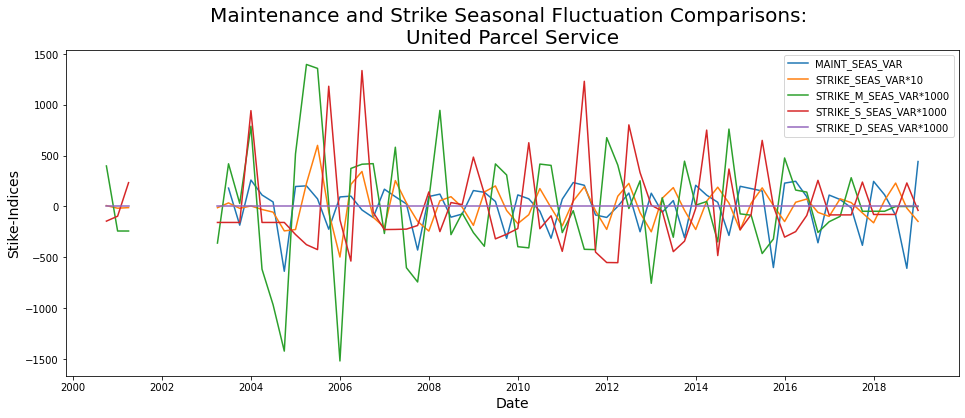

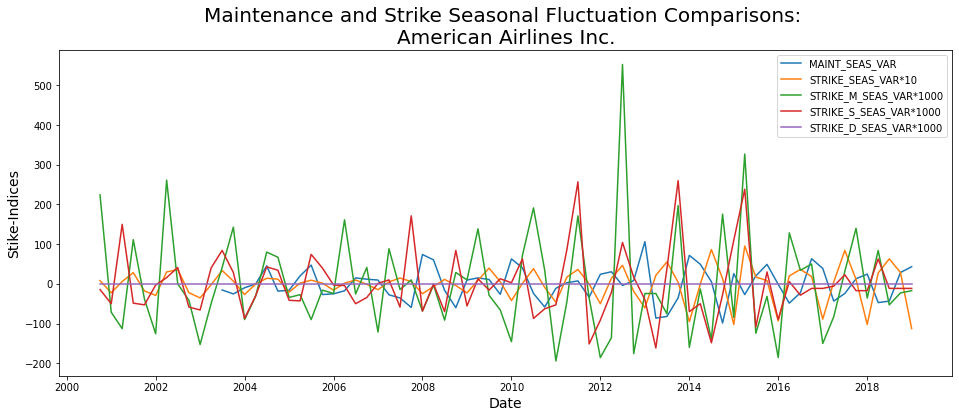

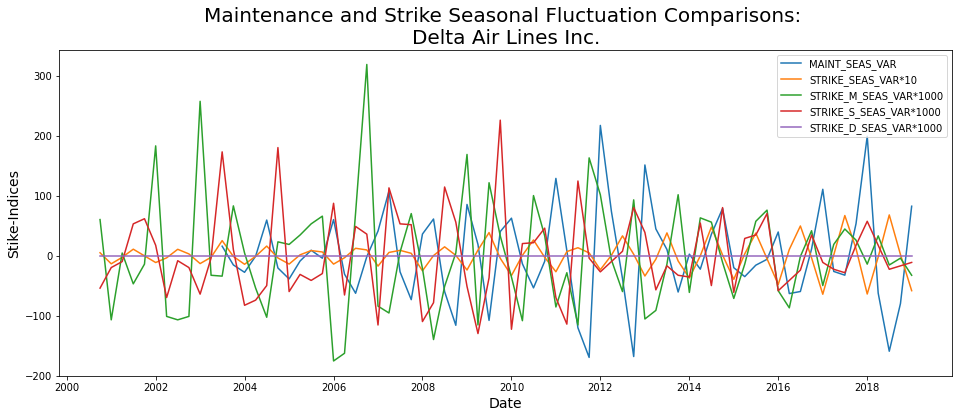

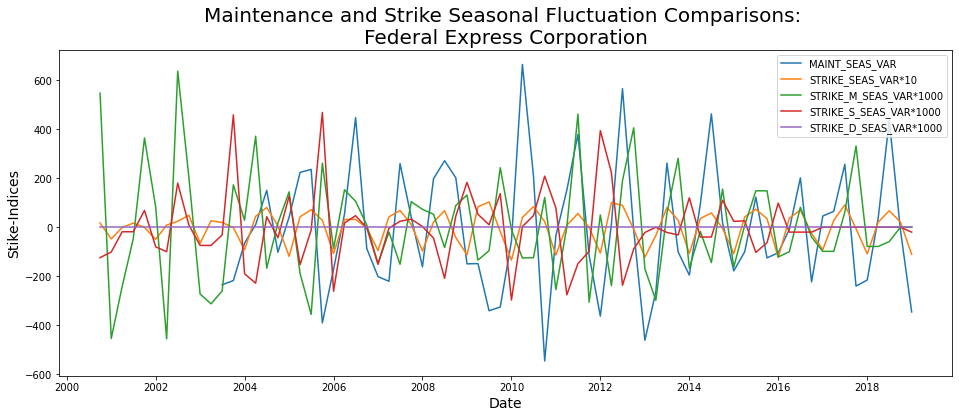

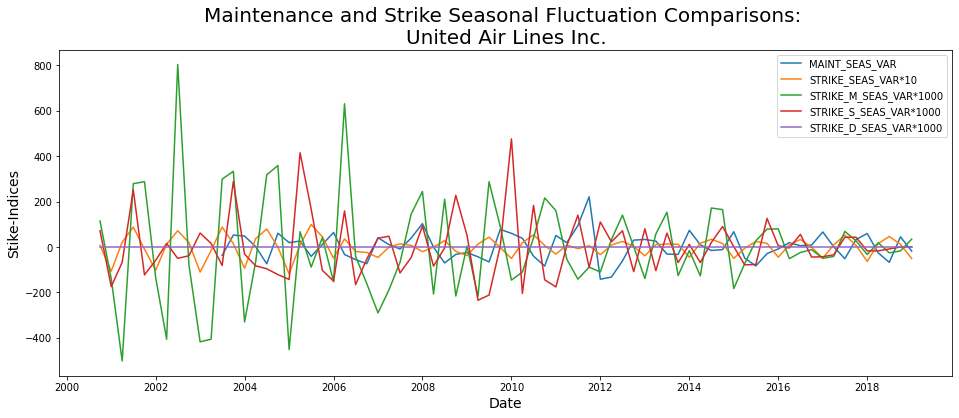

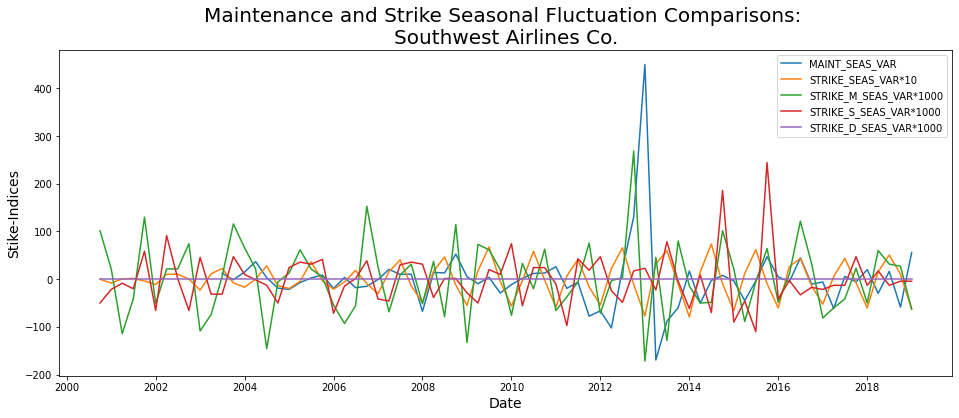

In [45]:
for code in IATA:
    plt.figure(figsize=(16,6))

    # We scale the STRIKE_M_SEAS_VAR, STRIKE_M_SEAS_VAR, and STRIKE_M_SEAS_VAR variables so their peaks are 
    # more visible.
    plt.plot(expenses_dict[code].DATE, expenses_dict[code].MAINT_SEAS_VAR, label='MAINT_SEAS_VAR') 
    plt.plot(expenses_dict[code].DATE, expenses_dict[code].STRIKE_SEAS_VAR*10, label='STRIKE_SEAS_VAR*10')
    plt.plot(expenses_dict[code].DATE, expenses_dict[code].STRIKE_M_SEAS_VAR*1000, label='STRIKE_M_SEAS_VAR*1000')
    plt.plot(expenses_dict[code].DATE, expenses_dict[code].STRIKE_S_SEAS_VAR*1000, label='STRIKE_S_SEAS_VAR*1000')
    plt.plot(expenses_dict[code].DATE, expenses_dict[code].STRIKE_D_SEAS_VAR*1000, label='STRIKE_D_SEAS_VAR*1000')
    
    plt.xlabel("Date", fontsize = 14)
    plt.ylabel("Stike-Indices", fontsize = 14)
    plt.title('Maintenance and Strike Seasonal Fluctuation Comparisons: \n' + expenses_dict[code].AIRLINE.iloc[0], 
              fontsize = 20)
    
    plt.legend(fontsize=14)
    plt.legend()
    
    plt.show()

There does not appear to be any consistent alignment between the blue curves and any of the green, red, or magenta curves. There is some alignment between the orange and blue curves, but only for Fedex and UPS.

Let's see if a high cost of repairs from bird strikes in a quarter is associated with peaks in the MAINT_SEAS_VAR curve.

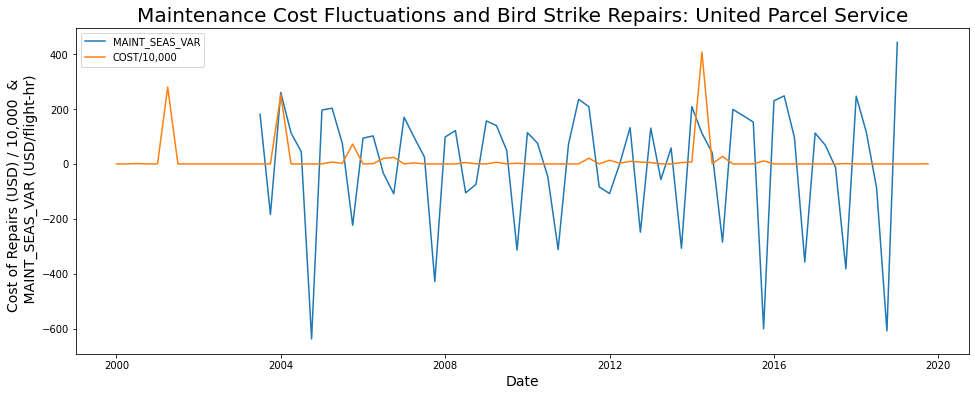

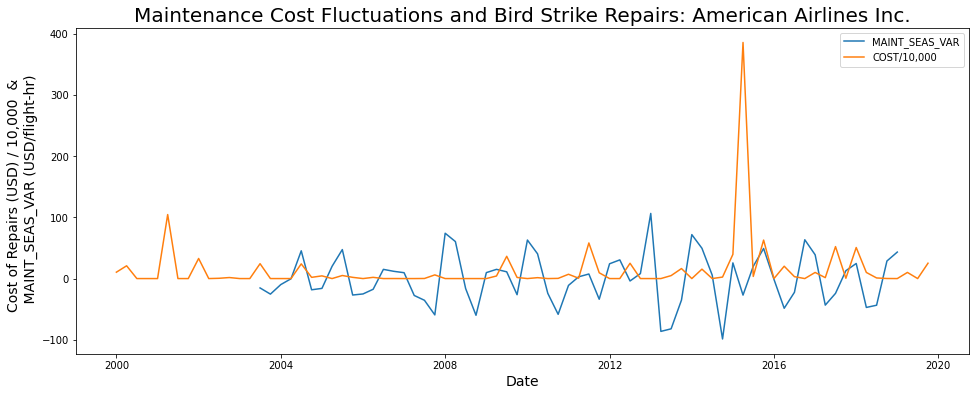

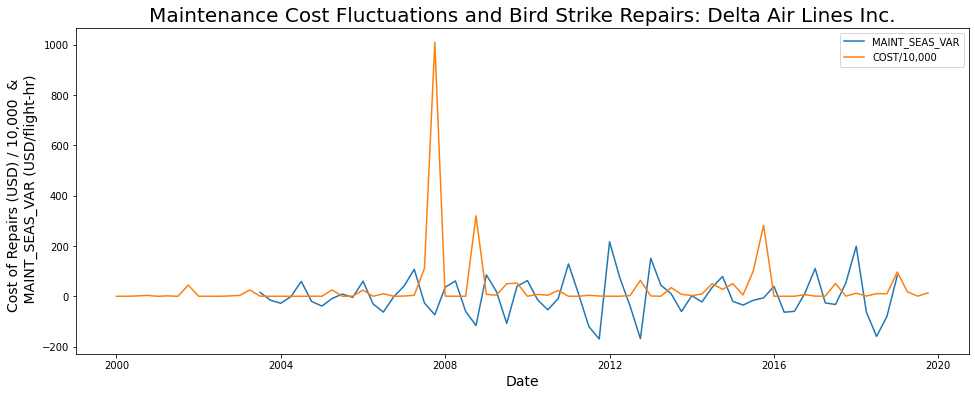

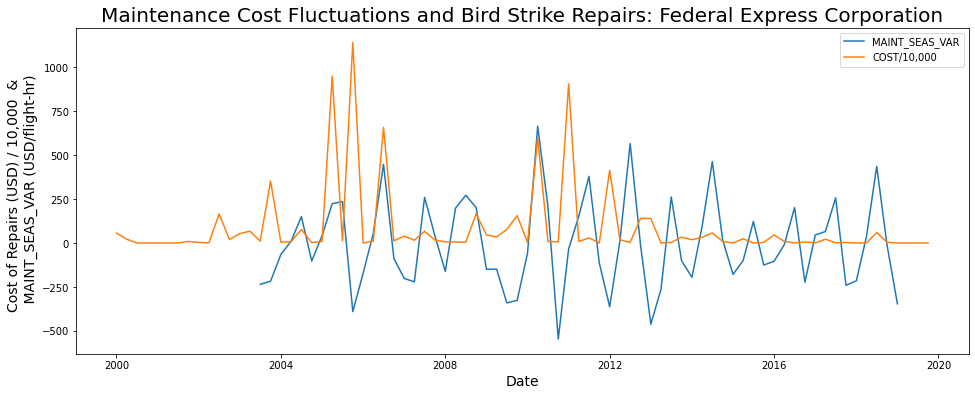

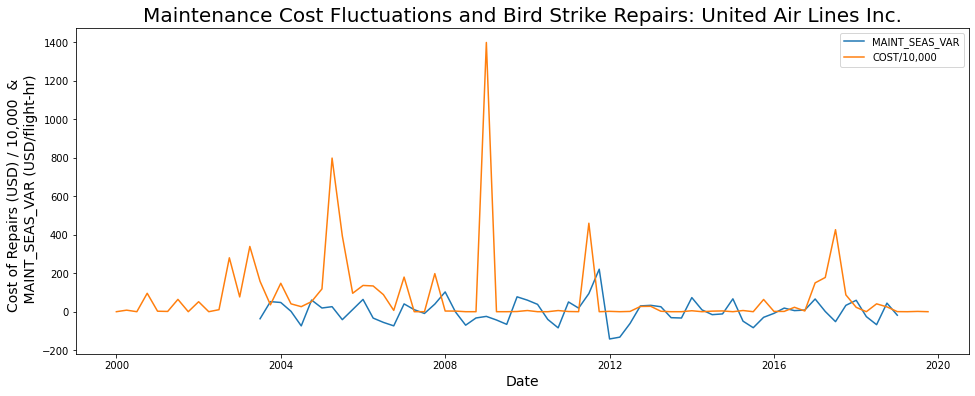

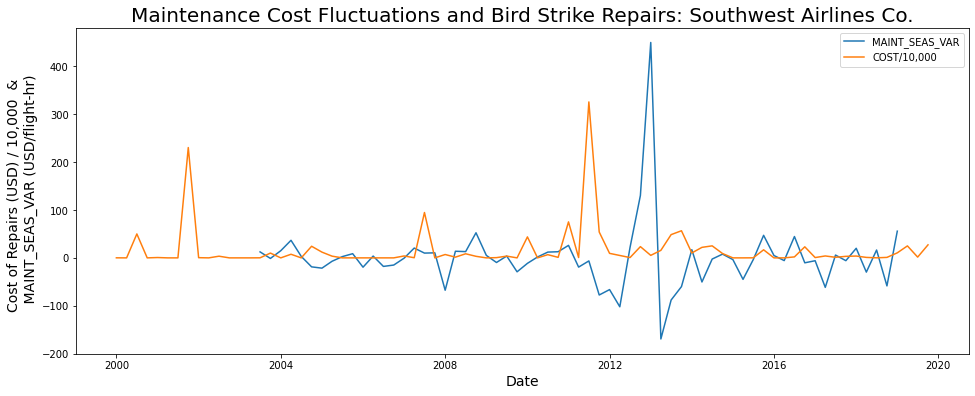

In [46]:
for code in IATA:
    plt.figure(figsize=(16,6))

    plt.plot(expenses_dict[code].DATE, expenses_dict[code].MAINT_SEAS_VAR, label='MAINT_SEAS_VAR') 
    plt.plot(expenses_dict[code].DATE, expenses_dict[code].COST/10000, label='COST/10,000')
    
    plt.xlabel("Date", fontsize = 14)
    plt.ylabel("Cost of Repairs (USD) / 10,000  &  \n MAINT_SEAS_VAR (USD/flight-hr)", fontsize = 14)
    plt.title('Maintenance Cost Fluctuations and Bird Strike Repairs: ' + expenses_dict[code].AIRLINE.iloc[0], 
              fontsize = 20)
    
    plt.legend(fontsize=14)
    plt.legend()
    
    plt.show()

Even the costs of repairs of bird strikes do not seem to be closely associated with fluctuations in the maintenance costs.

To get a better idea of why this is the case, we graph the total direct maintenance costs next to the cost of repairs from bird strikes.

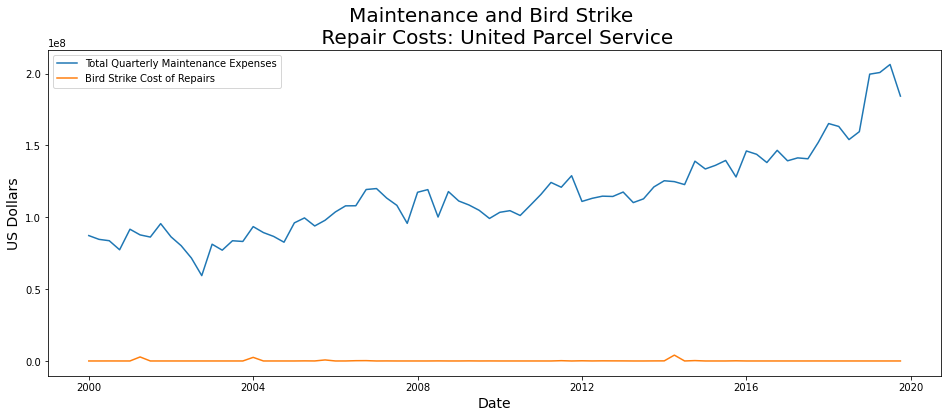

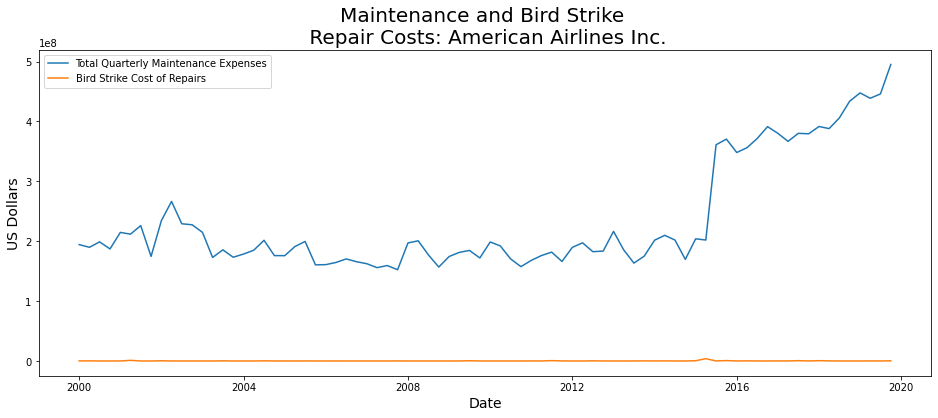

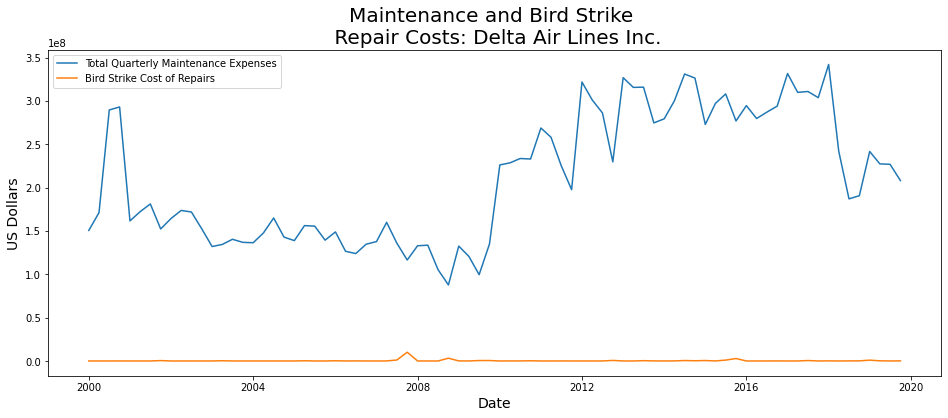

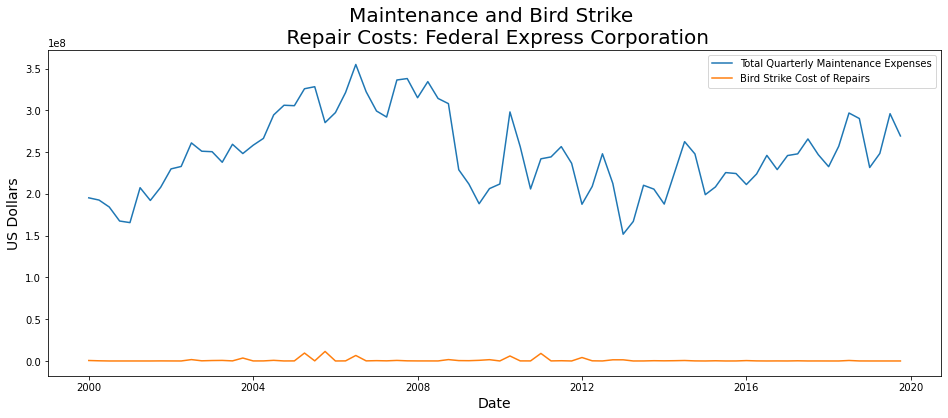

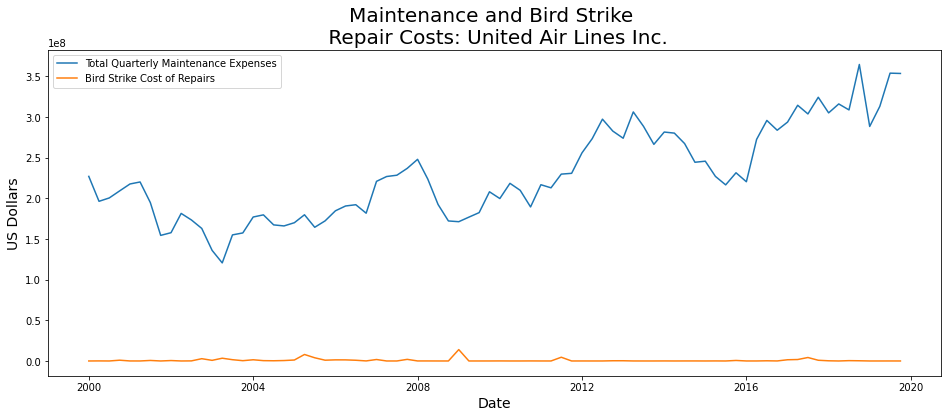

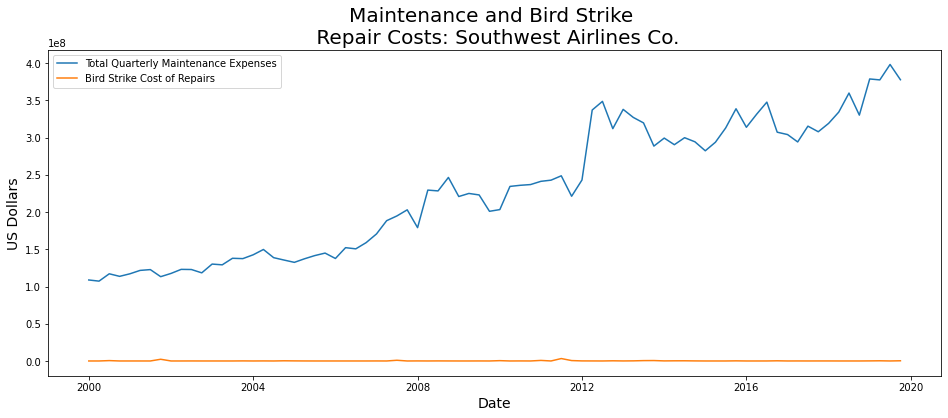

In [47]:
for code in IATA:
    plt.figure(figsize=(16,6))

    plt.plot(expenses_dict[code].DATE, expenses_dict[code].TOT_DIR_MAINT*1000, label='Total Quarterly Maintenance Expenses') 
    plt.plot(expenses_dict[code].DATE, expenses_dict[code].COST, label='Bird Strike Cost of Repairs')
    
    plt.xlabel("Date", fontsize = 14)
    plt.ylabel("US Dollars", fontsize = 14)
    plt.title('Maintenance and Bird Strike \n Repair Costs: ' + expenses_dict[code].AIRLINE.iloc[0], 
              fontsize = 20)
    
    plt.legend(fontsize=14)
    plt.legend()
    
    plt.show()

Given that bird strike repairs make up such a miniscule amount of total maintenance costs, it is not surprising that we did not see an effect of bird strikes on the seasonality of the mainenance costs.

To make our negative findings more precise, we can check that there is no robust correlation between 'TOT_DIR_MAINT', 'ADJ_MAINT', or 'MAINT_SEAS_VAR' and the wildlife strikes variables which is consitent across different airlines.

In [48]:
for code in IATA:
    print( )
    print( )
    print(code)
    print(expenses_dict[code][['TOT_DIR_MAINT', 'ADJ_MAINT', 'MAINT_SEAS_VAR', 'COST', 'COUNT', 'DAMAGE_M', 
                               'DAMAGE_S', 'STRIKE_INDEX', 'STRIKE_INDEX_M', 'STRIKE_INDEX_S', 'STRIKE_SEAS_VAR', 
                               'STRIKE_M_SEAS_VAR', 'STRIKE_S_SEAS_VAR']].corr()[['TOT_DIR_MAINT', 
                                                                                  'ADJ_MAINT', 'MAINT_SEAS_VAR']])



UPS
                   TOT_DIR_MAINT  ADJ_MAINT  MAINT_SEAS_VAR
TOT_DIR_MAINT           1.000000   0.784249        0.126283
ADJ_MAINT               0.784249   1.000000        0.561938
MAINT_SEAS_VAR          0.126283   0.561938        1.000000
COST                   -0.073490   0.040985        0.095854
COUNT                   0.136512  -0.006520        0.004745
DAMAGE_M               -0.185576  -0.295328        0.071270
DAMAGE_S               -0.013373  -0.038512       -0.031233
STRIKE_INDEX            0.089736   0.023992        0.050069
STRIKE_INDEX_M         -0.207294  -0.275779        0.093099
STRIKE_INDEX_S         -0.023617  -0.002058        0.013149
STRIKE_SEAS_VAR        -0.053973   0.039416        0.060827
STRIKE_M_SEAS_VAR       0.043752   0.078916        0.142465
STRIKE_S_SEAS_VAR       0.041578   0.015542       -0.012499


AAL
                   TOT_DIR_MAINT  ADJ_MAINT  MAINT_SEAS_VAR
TOT_DIR_MAINT           1.000000   0.890223        0.176773
ADJ_MAINT               0.89